In [ ]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import json
from pyecharts import options as opts
from pyecharts.charts import Graph,Page
from pyecharts.charts import Sunburst

%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

global minVal,maxVal
maxVal=0.0
minVal=0.0

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


##灰色关联分析模型计算方法
class GCoeffience(object):
    def __init__(self,fpath,rou):
        self.fpath = fpath
        self.rou = rou
        
        self.rawData=self.getData()
        
        self.node_size=self.rawData.mean(axis=1)*400/self.rawData.mean(axis=1).sum()
        
        self.labels=self.rawData.index.values
        
        self.resData=pd.DataFrame()
        
        self.outData,self.relation=self.getLoopData()
        
    def getData(self):
        data=pd.read_excel(filepath,encoding='utf-8_sig',
                      index_col=0)
        return data
    
    def calCoef(self,rdata):
        dval=minVal+rou*maxVal/(rdata+rou*maxVal)
        return dval
      
    def getLoopData(self):
        global minVal,maxVal
        self.resData.reindex=self.rawData.index
        columns=self.rawData.index.values

        rows,cols=self.rawData.shape
        for i in range(rows):
            normData=self.rawData/self.rawData.iloc[i]
            absData=abs(normData-normData.iloc[i])
            maxVal=max(absData.max())
            minVal=min(absData.min())

            glxs=absData.apply(lambda row:self.calCoef(row))
            self.resData[columns[i]]=glxs.mean(axis=1)
    #         print(glxs.mean(axis=1))
    #     dataw=df.as_matrix()
        dataT=self.resData.values.T
        relation=(self.resData.values+dataT)/2
        newdf=pd.DataFrame(dataT,columns=columns)
        newdf.index=self.rawData.index
#         print(newdf)
        return newdf,np.triu(relation)

    def show_labels(self):
        labls={}
        for (lbl,ns) in zip(self.labels,self.node_size.values):
            if ns >=25:
                labls[lbl]=lbl
        print(labls)
        return labls

    def create_ntx_pds(self):
        self.outData[self.outData<0.56]=0
        G=nx.from_pandas_adjacency(self.outData,create_using = nx.MultiGraph)
        pos=nx.spring_layout(G)
        
        pd_labels=self.show_labels()
        nx.draw_networkx_edges(G,pos,with_labels=False,edge_color='blue',
                              alpha=0.8,width=[float(v['weight']*5) for (r,c,v) in G.edges(data=True)])
        nx.draw_networkx_labels(G,pos,pd_labels,font_size=12)
        nx.draw_networkx(G,pos,node_size=self.node_size.values,with_labels=False)

    def create_ntx_mat(self):
        G=nx.from_numpy_matrix(self.relation,create_using=nx.MultiDiGraph)
        pos=nx.spring_layout(G)
        labls=show_labels(self.labels,self.node_size.values)
    #     nx.draw(G)
    #     nx.draw_networkx_labels(G,pos,labls,font_size=12)
        nx.draw_networkx(G,pos,node_size=self.node_size,
                        with_labels=False)
        
    def show_graph(self):
        plt.axis('off')
        plt.show()
        
    
##产业启信宝数据得解析，并得到echart数据之间得联系
class CyParseModel(object):
    def __init__(self,origPath,outPath):
        self.fpath=origPath
        self.outpath=outPath
        
        self.rawData=self.getData()
        
        self.cy_weight_data,self.hy_weight_data,self.xl_weight_data=self.node_weight()
        
        self.total_cy_dict,self.total_dl_dict=self.get_cy_data_link()
        
        self.NodesJson=self.genNode()
        self.EdgesJson=self.genEdges()
        self.CatsJson=self.genCateries()
        
        self.AllData=[self.NodesJson,self.EdgesJson,self.CatsJson]
        
    def getData(self):
        data=pd.read_csv(self.fpath,encoding='utf-8_sig',index_col=4)
        prcData=data.drop_duplicates()
        return prcData
    
    def node_weight(self):
        hy_weight_data={}
        cy_weight_data={}
        xl_weight_data={}
        
#         min_ptcs=self.rawData[u'企业数量'].groupby([self.rawData['行业大类']]).sum().min()

        cy_data=(self.rawData[u'企业数量'].groupby([self.rawData['产业类别']]).sum()).apply(lambda row:round(row,3))
        xl_data=(self.rawData[u'企业数量']).apply(lambda row:round(row,3))
#         xl_data=(self.rawData[u'企业数量'].groupby([self.rawData['行业小类']]).sum()/min_ptcs).apply(lambda row:round(row,3))

        cy_weight_data=dict(cy_data)
        xl_weight_data=dict(xl_data)
        
        hy_weight_data={}
        cy_grp=self.rawData[[u'企业数量',u'行业大类']].groupby([self.rawData['产业类别']])
        for cy,val in cy_grp:
            hy_grp=val[u'企业数量'].groupby(val[u'行业大类']).sum()
            for key,val in dict(hy_grp).items():
                hy_weight_data[(cy,key)]=val

        return cy_weight_data,hy_weight_data,xl_weight_data
    
    def getCyValue(self):
        cy_data=self.rawData[u"行业大类"].groupby(self.rawData['产业类别'])
        return dict(cy_data.count())
    
    def get_cy_data_link(self):
        total_cy_dict=defaultdict(dict)
        total_dl_dict=defaultdict(dict)
        
#         min_ptcs=sorted(list(self.hy_weight_data.values()))[1]
        hy_grpData=self.rawData[u'企业数量'].groupby([self.rawData['产业类别'],self.rawData['行业大类']])
        
        cy_value_wg=self.getCyValue()
    
        cy_total=sum(list(self.cy_weight_data.values()))
        hy_total=sum(list(self.hy_weight_data.values()))
        
        for (cy,dl),val in hy_grpData:
#             print("&&&&&&&&&&%s&&&&&&&&&%s"%(cy,dl))
            for (xl,vals) in val.items():
                tem_dict={}
                tem_dict['nodeSize']=vals
                tem_dict['link']=0
#                 tem_dict['nodeSize']=round(vals/min_ptcs,4)
#                 tem_dict['width']=round(vals/self.hy_weight_data[(cy,dl)],4)
                total_dl_dict[(cy,dl)][xl]=tem_dict
            total_dl_dict[(cy,dl)]['nodeSize']=self.hy_weight_data[(cy,dl)]
            total_dl_dict[(cy,dl)]['link']=val.count()
            
#             total_dl_dict[(cy,dl)]['width']=round(self.hy_weight_data[(cy,dl)]/self.cy_weight_data[cy],4)
            total_cy_dict[cy]['nodeSize']=self.cy_weight_data[cy]
            total_cy_dict[cy]['link']=cy_value_wg[cy]
            total_cy_dict[cy][(cy,dl)]=total_dl_dict[(cy,dl)]
        
#         print(total_cy_dict)
        return total_cy_dict,total_dl_dict

    def get_cy_data_width(self):
        total_cy_dict=defaultdict(dict)
        total_dl_dict=defaultdict(dict)
        
#         min_ptcs=sorted(list(self.hy_weight_data.values()))[1]
        hy_grpData=self.rawData[u'企业数量'].groupby([self.rawData['产业类别'],self.rawData['行业大类']])
        
        cy_total=sum(list(self.cy_weight_data.values()))
        hy_total=sum(list(self.hy_weight_data.values()))
        
        for (cy,dl),val in hy_grpData:
#             print("&&&&&&&&&&%s&&&&&&&&&%s"%(cy,dl))
            for (xl,vals) in dict(val).items():
                tem_dict={}
                tem_dict['nodeSize']=vals
#                 tem_dict['nodeSize']=round(vals/min_ptcs,4)
                tem_dict['width']=round(vals/self.hy_weight_data[(cy,dl)],4)
                total_dl_dict[(cy,dl)][xl]=tem_dict
                total_dl_dict[(cy,dl)]['nodeSize']=self.hy_weight_data[(cy,dl)]
#             total_dl_dict[(cy,dl)]['nodeSize']=round(self.hy_weight_data[(cy,dl)]/min_ptcs,4)
            total_dl_dict[(cy,dl)]['width']=round(self.hy_weight_data[(cy,dl)]/self.cy_weight_data[cy],4)
            total_cy_dict[cy]['nodeSize']=self.cy_weight_data[cy]
#             total_cy_dict[cy]['nodeSize']=round(self.cy_weight_data[cy]/min_ptcs,4)
            total_cy_dict[cy]['width']=round(self.cy_weight_data[cy]/cy_total,4)
            total_cy_dict[cy][(cy,dl)]=total_dl_dict[(cy,dl)]
        
#         print(total_cy_dict)
        return total_cy_dict,total_dl_dict
     
    def genCateries(self):
        catsList=[]
        keys=self.total_dl_dict.keys()
        
        temp={}
        i=0
        for (cy,dl) in keys:
            if cy not in temp.keys():
                temp[cy]=i
                catsList.append({"name":cy})
            if dl not in temp.keys():
                temp[dl]=i+1
                catsList.append({"name":dl})
        del temp
        return catsList
    
    def genEdges(self):
        edgesList=[]
        tem_dict={}
        i=0
        edgesList.append({"source":u"第一产业","target":u"第三产业"})
        edgesList.append({"source":u"第二产业","target":u"第三产业"})
        for ((cy,dl)),dvals in self.total_dl_dict.items():
            if (cy,dl) not in tem_dict.keys():
                edgesList.append({"source":cy,"target":dl})
                tem_dict[(cy,dl)]=i
            for xl,cvals in dvals.items():
                if (dl,xl) not in tem_dict.keys() and xl!="link" and xl !="nodeSize":
                    edgesList.append({"source":dl,"target":xl})
                    tem_dict[(dl,xl)]=i+1
        del tem_dict
        return edgesList
    
    def getLevel(self,k):
        if k>100000:
            return 25
        elif k>=50000:
            return 18
        elif k>=10000:
            return 11
        elif k>=4000:
            return 9
        elif k>=2000:
            return 6
        else:
            return 2
    
    def getCyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=cy
#         tem_dict["symbolSize"]=self.total_cy_dict[cy]['nodeSize']
        if cy==u"第一产业":
            tem_dict["symbolSize"]=12
        elif cy==u"第二产业":
            tem_dict["symbolSize"]=26
        else:
            tem_dict["symbolSize"]=30
#         tem_dict["symbolSize"]=self.getLevel(self.total_cy_dict[cy]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_cy_dict[cy]['link']
#         tem_dict["value"]=tem_dict["symbolSize"]
        tem_dict["category"]=cy
        if self.getLevel(tem_dict["symbolSize"])>7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
        return tem_dict

    def getHyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=dl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_dl_dict[(cy,dl)]['link']
#             tem_dict["value"]=int(self.total_dl_dict[(cy,dl)]['width']*10)
        tem_dict["category"]=cy
        if tem_dict["symbolSize"]>=7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
#         tem_dict["lable"]={"normal":{"show":"True"}}
        return tem_dict
    
    def getXlTempDict(self,cy,dl,xl):
        tem_dict={}
        tem_dict["name"]=xl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)][xl]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=0
        if tem_dict["symbolSize"]>7:
            tem_dict["label"]={"normal":{"show":"True"}}
#         if self.total_dl_dict[(cy,dl)][xl]['link']*10<1:
#             tem_dict["value"]=1
#         else:
#             tem_dict["value"]=int(self.total_dl_dict[(cy,dl)][xl]['width']*10)
        tem_dict["category"]=dl
        return tem_dict
    
    def genNode(self):
        nodesList=[]
        cy_dict={}
        hy_dict={}
        i=0
        for ((cy,dl),dval) in self.total_dl_dict.items():
            if cy not in cy_dict:
                tem_dict=self.getCyTempDict(cy,dl)
                i=i+1
                cy_dict[cy]=i
                nodesList.append(tem_dict)
            if dl not in cy_dict:
                dl_dict=self.getHyTempDict(cy,dl)
                i=i+1
                cy_dict[dl]=i
                nodesList.append(dl_dict)
                del dl_dict
            for xl,xval in dval.items():
                if xl=="nodeSize" or xl=="link":
                    continue
                if xl not in cy_dict:
                    xl_dict=self.getXlTempDict(cy,dl,xl)
                    i=i+1
                    cy_dict[xl]=i
                    nodesList.append(xl_dict)
                    del xl_dict
        print(len(nodesList))
        return nodesList
    
    def genSunBurstJson(self):
        pass
    
    
    def genJson(self):
        with open(self.outpath,'w',encoding='utf-8') as f:
            json.dump(self.AllData,f,ensure_ascii=False,cls=NpEncoder)
        
class CreateGraph():
    def __init__(self,jsonPath):
        
        self.jpath=jsonPath
        
    
    def graph_weibo(self) ->Graph:
        with open(self.jpath, "r", encoding="utf-8_sig") as f:
            j = json.load(f)
            nodes, links, categories = j
        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="900px"))
            .add(
                "",
                nodes,
                links,
                categories,
                repulsion=100,
                linestyle_opts=opts.LineStyleOpts(curve=0.2),
                label_opts=opts.LabelOpts(is_show=False),
            )
            .set_global_opts(
                legend_opts=opts.LegendOpts(is_show=False),
                title_opts=opts.TitleOpts(title="产业 — 行业关系图"),
            )
        )
        return c
    
    def graph_les_miserables() -> Graph:
        with open('self.lspath', "r",encoding="utf-8") as f:
            j = json.load(f)
            nodes = j["nodes"]
            links = j["links"]
            categories = j["categories"]

        c = (
             Graph(init_opts=opts.InitOpts(width="1000px", height="600px")).add("",
                nodes=nodes,
                links=links,
                categories=categories,
                layout="circular",
                is_rotate_label=True,
                linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
                label_opts=opts.LabelOpts(position="right"),).set_global_opts(
                title_opts=opts.TitleOpts(title="Graph-Les Miserables"),
                legend_opts=opts.LegendOpts(
                    orient="vertical", pos_left="2%", pos_top="20%"
                ),)
        )
        return c
    
    def graph_npm_dependencies(self) -> Graph:
        with open('self.nmpath', "r", encoding="utf-8") as f:
            j = json.load(f)
        nodes = [
            {
                "x": node["x"],
                "y": node["y"],
                "id": node["id"],
                "name": node["label"],
                "symbolSize": node["size"],
                "itemStyle": {"normal": {"color": node["color"]}},
            }
            for node in j["nodes"]
        ]

        edges = [
            {"source": edge["sourceID"], "target": edge["targetID"]} for edge in j["edges"]
        ]

        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="600px"))
            .add(
                "",
                nodes=nodes,
                links=edges,
                layout="none",
                label_opts=opts.LabelOpts(is_show=False),
                linestyle_opts=opts.LineStyleOpts(width=0.5, curve=0.3, opacity=0.7),
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Graph-NPM Dependencies"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_base(self) -> Sunburst:
        data=[
            opts.SunburstItem(
                name='Grandpa',
                children=[
                    opts.SunburstItem(
                        name='uncle Leo',
                        value=15,
                        children=[
                            opts.SunburstItem(name='jack',value=2),
                            opts.SunburstItem(name='Margy',value=5,
                                             children=[opts.SunburstItem(name='Jackson',value=2)]),
                            opts.SunburstItem(name='Ben',value=4)
                        ],
                    ),
                    opts.SunburstItem(name='Father',value=10,
                                     children=[
                                         opts.SunburstItem(name='me',value=5),
                                         opts.SunburstItem(name='b pter',value=2)
                                     ]),
                ],
            ),
                opts.SunburstItem(
                name="Nancy",
                children=[
                    opts.SunburstItem(
                        name="Uncle Nike",
                        children=[
                            opts.SunburstItem(name="Cousin Betty", value=1),
                            opts.SunburstItem(name="Cousin Jenny", value=2),
                        ],
                    )
                ],
            ),
        ]
        c=(
            Sunburst()
            .add(series_name="", data_pair=data, radius=[0, "90%"])
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-基本示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_official(self) -> Sunburst:
        with open(r'C:\Users\Administrator\Desktop\hsgl\drink.json','r',encoding='utf-8') as f:
            j=json.load(f)
        gph=(
            Sunburst(init_opts=opts.InitOpts(width='1000px',height='600px'))
            .add(
                '',data_pair=j,highlight_policy='ancestor',
                radius=[0,'95%'],sort_='null',
                levels=[
                    {},
                    {'r0':'15%','r':'35%','itemStyle':{'borderWidth':2},
                     'lable':{'rotate':'tangential'},},
                    {'r0':'35%','r':'70%','lable':{'align':'right'}},
                    {
                        'ro':'70%',
                        'r':'72%',
                        'label':{'position':'outside','padding':3,'silent':False},
                        'itemStyle':{'borderWidth':3},
                    },
                ],
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-官方示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return gph 


if __name__=="__main__":
    origPath=r'C:\Users\Administrator\Desktop\tpTest\hygs_qxb.csv'
    outPath=r'C:\Users\Administrator\Desktop\tpTest\cyjieguo4.json'
    cyModel=CyParseModel(origPath,outPath)
#     print(cyModel.total_dl_dict)
    cyModel.genJson()
    cgraph=CreateGraph(outPath)
    cg=cgraph.graph_weibo()
    cg.render(r'C:\Users\Administrator\Desktop\tpTest\产业关系图2.html')
    print('success')

In [ ]:
##下面的模块是专门生成关系图的产业模块

In [ ]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import json
from pyecharts import options as opts
from pyecharts.charts import Graph,Page
from pyecharts.charts import Sunburst

%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

##产业启信宝数据的解析，并得到echart数据之间得联系
class CyParseModel(object):
    def __init__(self,origPath,outPath):
        self.fpath=origPath
        self.outpath=outPath
        
        self.rawData=self.getData()
        
        self.cy_weight_data,self.hy_weight_data,self.xl_weight_data=self.node_weight()
        
        self.total_cy_dict,self.total_dl_dict=self.get_cy_data_link()
        
        self.NodesJson=self.genNode()
        self.EdgesJson=self.genEdges()
        self.CatsJson=self.genCateries()
        
        self.AllData=[self.NodesJson,self.EdgesJson,self.CatsJson]
        
    def getData(self):
        data=pd.read_csv(self.fpath,encoding='utf-8_sig',index_col=4)
        prcData=data.drop_duplicates()
        return prcData
    
    def node_weight(self):
        hy_weight_data={}
        cy_weight_data={}
        xl_weight_data={}
        
#         min_ptcs=self.rawData[u'企业数量'].groupby([self.rawData['行业大类']]).sum().min()

        cy_data=(self.rawData[u'企业数量'].groupby([self.rawData['产业类别']]).sum()).apply(lambda row:round(row,3))
        xl_data=(self.rawData[u'企业数量']).apply(lambda row:round(row,3))
#         xl_data=(self.rawData[u'企业数量'].groupby([self.rawData['行业小类']]).sum()/min_ptcs).apply(lambda row:round(row,3))

        cy_weight_data=dict(cy_data)
        xl_weight_data=dict(xl_data)
        
        hy_weight_data={}
        cy_grp=self.rawData[[u'企业数量',u'行业大类']].groupby([self.rawData['产业类别']])
        for cy,val in cy_grp:
            hy_grp=val[u'企业数量'].groupby(val[u'行业大类']).sum()
            for key,val in dict(hy_grp).items():
                hy_weight_data[(cy,key)]=val

        return cy_weight_data,hy_weight_data,xl_weight_data
    
    def getCyValue(self):
        cy_data=self.rawData[u"行业大类"].groupby(self.rawData['产业类别'])
        return dict(cy_data.count())
    
    def get_cy_data_link(self):
        total_cy_dict=defaultdict(dict)
        total_dl_dict=defaultdict(dict)
        
#         min_ptcs=sorted(list(self.hy_weight_data.values()))[1]
        hy_grpData=self.rawData[u'企业数量'].groupby([self.rawData['产业类别'],self.rawData['行业大类']])
        
        cy_value_wg=self.getCyValue()
    
        cy_total=sum(list(self.cy_weight_data.values()))
        hy_total=sum(list(self.hy_weight_data.values()))
        
        for (cy,dl),val in hy_grpData:
#             print("&&&&&&&&&&%s&&&&&&&&&%s"%(cy,dl))
            for (xl,vals) in val.items():
                tem_dict={}
                tem_dict['nodeSize']=vals
                tem_dict['link']=0
#                 tem_dict['nodeSize']=round(vals/min_ptcs,4)
                tem_dict['width']=round(vals/self.hy_weight_data[(cy,dl)],4)
                total_dl_dict[(cy,dl)][xl]=tem_dict
            total_dl_dict[(cy,dl)]['nodeSize']=self.hy_weight_data[(cy,dl)]
            total_dl_dict[(cy,dl)]['link']=val.count()
            
            total_dl_dict[(cy,dl)]['width']=round(self.hy_weight_data[(cy,dl)]/self.cy_weight_data[cy],4)
            total_cy_dict[cy]['nodeSize']=self.cy_weight_data[cy]
            total_cy_dict[cy]['link']=cy_value_wg[cy]
            total_cy_dict[cy]['width']=round(self.cy_weight_data[cy]/cy_total,4)
            total_cy_dict[cy][(cy,dl)]=total_dl_dict[(cy,dl)]
        
        return total_cy_dict,total_dl_dict
     
    def genCateries(self):
        catsList=[]
        keys=self.total_dl_dict.keys()
        
        temp={}
        i=0
        for (cy,dl) in keys:
            if cy not in temp.keys():
                temp[cy]=i
                catsList.append({"name":cy})
            if dl not in temp.keys():
                temp[dl]=i+1
                catsList.append({"name":dl})
        del temp
        return catsList
    
    def genEdges(self):
        edgesList=[]
        tem_dict={}
        i=0
        edgesList.append({"source":u"第一产业","target":u"第三产业"})
        edgesList.append({"source":u"第二产业","target":u"第三产业"})
        for ((cy,dl)),dvals in self.total_dl_dict.items():
            if (cy,dl) not in tem_dict.keys():
                edgesList.append({"source":cy,"target":dl})
                tem_dict[(cy,dl)]=i
            for xl,cvals in dvals.items():
                if (dl,xl) not in tem_dict.keys() and xl!="link" and xl !="nodeSize":
                    edgesList.append({"source":dl,"target":xl})
                    tem_dict[(dl,xl)]=i+1
        del tem_dict
        return edgesList
    
    def getLevel(self,k):
        if k>100000:
            return 25
        elif k>=50000:
            return 18
        elif k>=10000:
            return 11
        elif k>=4000:
            return 9
        elif k>=2000:
            return 6
        else:
            return 2
    
    def getCyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=cy
#         tem_dict["symbolSize"]=self.total_cy_dict[cy]['nodeSize']
        if cy==u"第一产业":
            tem_dict["symbolSize"]=12
        elif cy==u"第二产业":
            tem_dict["symbolSize"]=26
        else:
            tem_dict["symbolSize"]=30
#         tem_dict["symbolSize"]=self.getLevel(self.total_cy_dict[cy]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_cy_dict[cy]['link']
#         tem_dict["value"]=tem_dict["symbolSize"]
        tem_dict["category"]=cy
        if self.getLevel(tem_dict["symbolSize"])>7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
        return tem_dict

    def getHyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=dl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_dl_dict[(cy,dl)]['link']
#             tem_dict["value"]=int(self.total_dl_dict[(cy,dl)]['width']*10)
        tem_dict["category"]=cy
        if tem_dict["symbolSize"]>=7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
#         tem_dict["lable"]={"normal":{"show":"True"}}
        return tem_dict
    
    def getXlTempDict(self,cy,dl,xl):
        tem_dict={}
        tem_dict["name"]=xl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)][xl]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=0
        if tem_dict["symbolSize"]>7:
            tem_dict["label"]={"normal":{"show":"True"}}
        tem_dict["category"]=dl
        return tem_dict
    
    def genNode(self):
        nodesList=[]
        cy_dict={}
        hy_dict={}
        i=0
        for ((cy,dl),dval) in self.total_dl_dict.items():
            if cy not in cy_dict:
                tem_dict=self.getCyTempDict(cy,dl)
                i=i+1
                cy_dict[cy]=i
                nodesList.append(tem_dict)
            if dl not in cy_dict:
                dl_dict=self.getHyTempDict(cy,dl)
                i=i+1
                cy_dict[dl]=i
                nodesList.append(dl_dict)
                del dl_dict
            for xl,xval in dval.items():
                if xl=="nodeSize" or xl=="link":
                    continue
                if xl not in cy_dict:
                    xl_dict=self.getXlTempDict(cy,dl,xl)
                    i=i+1
                    cy_dict[xl]=i
                    nodesList.append(xl_dict)
                    del xl_dict
        print(len(nodesList))
        return nodesList

    def genJson(self):
        with open(self.outpath,'w',encoding='utf-8') as f:
            json.dump(self.AllData,f,ensure_ascii=False,cls=NpEncoder)

        
        
####生成微博Json格式数据
class GraphJson():
    def __init__(self,total_cy_dict,total_dl_dict,outpath):
        self.total_cy_dict=total_cy_dict
        self.total_dl_dict=total_dl_dict
        self.outpath=outpath
    
    def genCateries(self):
        catsList=[]
        keys=self.total_dl_dict.keys()
        
        temp={}
        i=0
        for (cy,dl) in keys:
            if cy not in temp.keys():
                temp[cy]=i
                catsList.append({"name":cy})
            if dl not in temp.keys():
                temp[dl]=i+1
                catsList.append({"name":dl})
        del temp
        return catsList
    
    def genEdges(self):
        edgesList=[]
        tem_dict={}
        i=0
        edgesList.append({"source":u"第一产业","target":u"第三产业"})
        edgesList.append({"source":u"第二产业","target":u"第三产业"})
        for ((cy,dl)),dvals in self.total_dl_dict.items():
            if (cy,dl) not in tem_dict.keys():
                edgesList.append({"source":cy,"target":dl})
                tem_dict[(cy,dl)]=i
            for xl,cvals in dvals.items():
                if (dl,xl) not in tem_dict.keys() and xl!="link" and xl !="nodeSize":
                    edgesList.append({"source":dl,"target":xl})
                    tem_dict[(dl,xl)]=i+1
        del tem_dict
        return edgesList
    
    def getLevel(self,k):
        if k>100000:
            return 25
        elif k>=50000:
            return 18
        elif k>=10000:
            return 11
        elif k>=4000:
            return 9
        elif k>=2000:
            return 6
        else:
            return 2
    
    def getCyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=cy
#         tem_dict["symbolSize"]=self.total_cy_dict[cy]['nodeSize']
        if cy==u"第一产业":
            tem_dict["symbolSize"]=12
        elif cy==u"第二产业":
            tem_dict["symbolSize"]=26
        else:
            tem_dict["symbolSize"]=30
#         tem_dict["symbolSize"]=self.getLevel(self.total_cy_dict[cy]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_cy_dict[cy]['link']
#         tem_dict["value"]=tem_dict["symbolSize"]
        tem_dict["category"]=cy
        if self.getLevel(tem_dict["symbolSize"])>7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
        return tem_dict

    def getHyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=dl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_dl_dict[(cy,dl)]['link']
#             tem_dict["value"]=int(self.total_dl_dict[(cy,dl)]['width']*10)
        tem_dict["category"]=cy
        if tem_dict["symbolSize"]>=7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
#         tem_dict["lable"]={"normal":{"show":"True"}}
        return tem_dict
    
    def getXlTempDict(self,cy,dl,xl):
        tem_dict={}
        tem_dict["name"]=xl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)][xl]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=0
        if tem_dict["symbolSize"]>7:
            tem_dict["label"]={"normal":{"show":"True"}}
        tem_dict["category"]=dl
        return tem_dict
    
    def genNode(self):
        nodesList=[]
        cy_dict={}
        hy_dict={}
        i=0
        for ((cy,dl),dval) in self.total_dl_dict.items():
            if cy not in cy_dict:
                tem_dict=self.getCyTempDict(cy,dl)
                i=i+1
                cy_dict[cy]=i
                nodesList.append(tem_dict)
            if dl not in cy_dict:
                dl_dict=self.getHyTempDict(cy,dl)
                i=i+1
                cy_dict[dl]=i
                nodesList.append(dl_dict)
                del dl_dict
            for xl,xval in dval.items():
                if xl=="nodeSize" or xl=="link":
                    continue
                if xl not in cy_dict:
                    xl_dict=self.getXlTempDict(cy,dl,xl)
                    i=i+1
                    cy_dict[xl]=i
                    nodesList.append(xl_dict)
                    del xl_dict
        print(len(nodesList))
        return nodesList    
    
    def genJson(self):
        with open(self.outpath,'w',encoding='utf-8') as f:
            json.dump(self.AllData,f,ensure_ascii=False,cls=NpEncoder)
        

###根据启信宝的数据，利用pyechart对其进行可视化
class CreateGraph():
    def __init__(self,jsonPath):
        
        self.jpath=jsonPath
        
    
    def graph_weibo(self) ->Graph:
        with open(self.jpath, "r", encoding="utf-8_sig") as f:
            j = json.load(f)
            nodes, links, categories = j
        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="900px"))
            .add(
                "",
                nodes,
                links,
                categories,
                repulsion=100,
                linestyle_opts=opts.LineStyleOpts(curve=0.2),
                label_opts=opts.LabelOpts(is_show=False),
            )
            .set_global_opts(
                legend_opts=opts.LegendOpts(is_show=False),
                title_opts=opts.TitleOpts(title="产业 — 行业关系图",pos_left="center"),
            )
        )
        return c
    
    def graph_les_miserables() -> Graph:
        with open('self.lspath', "r",encoding="utf-8") as f:
            j = json.load(f)
            nodes = j["nodes"]
            links = j["links"]
            categories = j["categories"]

        c = (
             Graph(init_opts=opts.InitOpts(width="1000px", height="600px")).add("",
                nodes=nodes,
                links=links,
                categories=categories,
                layout="circular",
                is_rotate_label=True,
                linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
                label_opts=opts.LabelOpts(position="right"),).set_global_opts(
                title_opts=opts.TitleOpts(title="Graph-Les Miserables"),
                legend_opts=opts.LegendOpts(
                    orient="vertical", pos_left="2%", pos_top="20%"
                ),)
        )
        return c
    
    def graph_npm_dependencies(self) -> Graph:
        with open('self.nmpath', "r", encoding="utf-8") as f:
            j = json.load(f)
        nodes = [
            {
                "x": node["x"],
                "y": node["y"],
                "id": node["id"],
                "name": node["label"],
                "symbolSize": node["size"],
                "itemStyle": {"normal": {"color": node["color"]}},
            }
            for node in j["nodes"]
        ]

        edges = [
            {"source": edge["sourceID"], "target": edge["targetID"]} for edge in j["edges"]
        ]

        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="600px"))
            .add(
                "",
                nodes=nodes,
                links=edges,
                layout="none",
                label_opts=opts.LabelOpts(is_show=False),
                linestyle_opts=opts.LineStyleOpts(width=0.5, curve=0.3, opacity=0.7),
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Graph-NPM Dependencies"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_base(self) -> Sunburst:
        data=[
            opts.SunburstItem(
                name='Grandpa',
                children=[
                    opts.SunburstItem(
                        name='uncle Leo',
                        value=15,
                        children=[
                            opts.SunburstItem(name='jack',value=2),
                            opts.SunburstItem(name='Margy',value=5,
                                             children=[opts.SunburstItem(name='Jackson',value=2)]),
                            opts.SunburstItem(name='Ben',value=4)
                        ],
                    ),
                    opts.SunburstItem(name='Father',value=10,
                                     children=[
                                         opts.SunburstItem(name='me',value=5),
                                         opts.SunburstItem(name='b pter',value=2)
                                     ]),
                ],
            ),
                opts.SunburstItem(
                name="Nancy",
                children=[
                    opts.SunburstItem(
                        name="Uncle Nike",
                        children=[
                            opts.SunburstItem(name="Cousin Betty", value=1),
                            opts.SunburstItem(name="Cousin Jenny", value=2),
                        ],
                    )
                ],
            ),
        ]
        c=(
            Sunburst()
            .add(series_name="", data_pair=data, radius=[0, "90%"])
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-基本示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_official(self) -> Sunburst:
        with open(r'C:\Users\Administrator\Desktop\hsgl\drink.json','r',encoding='utf-8') as f:
            j=json.load(f)
        gph=(
            Sunburst(init_opts=opts.InitOpts(width='1000px',height='600px'))
            .add(
                '',data_pair=j,highlight_policy='ancestor',
                radius=[0,'95%'],sort_='null',
                levels=[
                    {},
                    {'r0':'15%','r':'35%','itemStyle':{'borderWidth':2},
                     'lable':{'rotate':'tangential'},},
                    {'r0':'35%','r':'70%','lable':{'align':'right'}},
                    {
                        'ro':'70%',
                        'r':'72%',
                        'label':{'position':'outside','padding':3,'silent':False},
                        'itemStyle':{'borderWidth':3},
                    },
                ],
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-官方示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return gph 
    
if __name__=="__main__":
    origPath=r'C:\Users\Administrator\Desktop\tpTest\hygs_qxb.csv'
    outPath=r'C:\Users\Administrator\Desktop\tpTest\cyjieguo4.json'
#     cyModel=CyParseModel(origPath,outPath)
#     print(cyModel.total_dl_dict)
#     cyModel.genJson()
    cgraph=CreateGraph(outPath)
    cg=cgraph.graph_weibo()
    cg.render(r'C:\Users\Administrator\Desktop\tpTest\产业关系图3.html')
    print('success')

{}


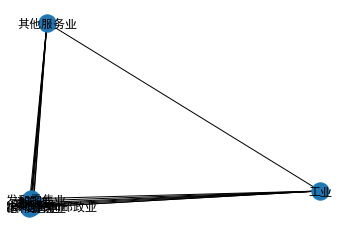

success


In [1]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import json
from pyecharts import options as opts
from pyecharts.charts import Graph,Page
from pyecharts.charts import Sunburst

%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

global minVal,maxVal
maxVal=0.0
minVal=0.0

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


##灰色关联分析模型计算方法
class GCoeffience(object):
    def __init__(self,fpath,rou):
        self.fpath = fpath
        self.rou = rou
        
        self.rawData=self.getData()
        
        self.node_size=self.rawData.mean(axis=1)*10/self.rawData.mean(axis=1).sum()
        
        self.labels=self.rawData.index.values
        
        self.resData=pd.DataFrame()
        
        self.outData,self.relation=self.getLoopData()
        
#         self.grph=self.createGrph()
        
#         self.pos=nx.spectral_layout(self.grph)
        
    def getData(self):
        data=pd.read_excel(filepath,encoding='utf-8_sig',
                      index_col=0)
        return data
    
    def calCoef(self,rdata):
        dval=minVal+rou*maxVal/(rdata+rou*maxVal)
        return dval
      
    def getLoopData(self):
        global minVal,maxVal
        self.resData.reindex=self.rawData.index
        columns=self.rawData.index.values

        rows,cols=self.rawData.shape
        for i in range(rows):
            normData=self.rawData/self.rawData.iloc[i]
            absData=abs(normData-normData.iloc[i])
            maxVal=max(absData.max())
            minVal=min(absData.min())

            glxs=absData.apply(lambda row:self.calCoef(row))
            self.resData[columns[i]]=glxs.mean(axis=1)
        dataT=self.resData.values.T
        relation=(self.resData.values+dataT)/2
        newdf=pd.DataFrame(dataT,columns=columns)
        newdf.index=self.rawData.index
        return newdf,np.triu(relation)
    
    def createGrph(self):
        G=nx.from_pandas_adjacency(self.outData,create_using=nx.MultiGraph)
        return G
    
    def show_labels(self):
        labls={}
        for (lbl,ns) in zip(self.labels,self.node_size.values):
            if ns >=25:
                labls[lbl]=lbl
        print(labls)
        return labls

    def create_ntx_pds(self):
#         self.outData[self.outData<0.5]=0
        G=nx.from_pandas_adjacency(self.outData,create_using = nx.Graph)
#         pos=nx.spring_layout(G)
        pos=nx.spectral_layout(G)
        
        pd_labels=self.show_labels()
#         nx.draw_networkx_edges(G,pos,with_labels=False,edge_color='blue',
#                                alpha=0.8,width=[float(v['weight']*50) for (r,c,v) in G.edges(data=True)])
#         nx.draw_networkx_edges(G,pos,with_labels=False,edge_color='blue',
#                               alpha=0.8,width=[float(v['weight']*50) for (r,c,v) in G.edges(data=True)])
        nx.draw_networkx_labels(G,pos,pd_labels,font_size=12)
#         nx.draw_networkx(G,pos,node_size=self.node_size.values,with_labels=False)
        nx.draw_spectral(G,with_labels=True)

    def create_ntx_mat(self):
        G=nx.from_numpy_matrix(self.relation,create_using=nx.MultiDiGraph)
        pos=nx.spring_layout(G)
#         labls=show_labels(self.labels,self.node_size.values)
    #     nx.draw(G)
    #     nx.draw_networkx_labels(G,pos,labls,font_size=12)
        nx.draw_networkx(G,pos,node_size=self.node_size,with_labels=False)
        
    def show_graph(self):
        plt.axis('off')
        plt.show()
        

if __name__=="__main__":
    filepath=r'C:\Users\Administrator\Desktop\hsgl\rawdata.xlsx'
    rou=0.5
    gcoffience=GCoeffience(filepath,rou)
    gcoffience.create_ntx_pds()
    gcoffience.show_graph()
#     print(gcoffience.resData)
#     origPath=r'C:\Users\Administrator\Desktop\tpTest\hygs_qxb.csv'
#     outPath=r'C:\Users\Administrator\Desktop\tpTest\cyjieguo4.json'
#     cyModel=CyParseModel(origPath,outPath)
# #     print(cyModel.total_dl_dict)
#     cyModel.genJson()
#     cgraph=CreateGraph(outPath)
#     cg=cgraph.graph_weibo()
#     cg.render(r'C:\Users\Administrator\Desktop\tpTest\产业关系图2.html')
    print('success')

In [ ]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import json
from pyecharts import options as opts
from pyecharts.charts import Graph,Page
from pyecharts.charts import Sunburst

%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

    



In [47]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import json,random
from pyecharts import options as opts
from pyecharts.charts import Graph,Page
from pyecharts.charts import Sunburst
from collections import OrderedDict

%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

##产业启信宝数据得解析，并得到echart数据之间得联系
class CyParseModel(object):
    def __init__(self,origPath,outPath):
        self.fpath=origPath
        self.outpath=outPath
        
        self.rawData=self.getData()
        
        self.cy_weight_data,self.hy_weight_data,self.xl_weight_data=self.node_weight()
        
        self.total_cy_dict,self.total_dl_dict=self.get_cy_data_link()
      
    def getData(self):
        data=pd.read_csv(self.fpath,encoding='utf-8_sig',index_col=4)
        prcData=data.drop_duplicates()
        return prcData
    
    def node_weight(self):
        hy_weight_data={}
        cy_weight_data={}
        xl_weight_data={}
        
#         min_ptcs=self.rawData[u'企业数量'].groupby([self.rawData['行业大类']]).sum().min()

        cy_data=(self.rawData[u'企业数量'].groupby([self.rawData['产业类别']]).sum()).apply(lambda row:round(row,3))
        xl_data=(self.rawData[u'企业数量']).apply(lambda row:round(row,3))
#         xl_data=(self.rawData[u'企业数量'].groupby([self.rawData['行业小类']]).sum()/min_ptcs).apply(lambda row:round(row,3))

        cy_weight_data=dict(cy_data)
        xl_weight_data=dict(xl_data)
        
        hy_weight_data={}
        cy_grp=self.rawData[[u'企业数量',u'行业大类']].groupby([self.rawData['产业类别']])
        for cy,val in cy_grp:
            hy_grp=val[u'企业数量'].groupby(val[u'行业大类']).sum()
            for key,val in dict(hy_grp).items():
                hy_weight_data[(cy,key)]=val

        return cy_weight_data,hy_weight_data,xl_weight_data
    
    def getCyValue(self):
        cy_data=self.rawData[u"行业大类"].groupby(self.rawData['产业类别'])
        return dict(cy_data.count())
    
    def get_cy_data_link(self):
        total_cy_dict=defaultdict(dict)
        total_dl_dict=defaultdict(dict)
        
#         min_ptcs=sorted(list(self.hy_weight_data.values()))[1]
        hy_grpData=self.rawData[u'企业数量'].groupby([self.rawData['产业类别'],self.rawData['行业大类']])
        
        cy_value_wg=self.getCyValue()
    
        cy_total=sum(list(self.cy_weight_data.values()))
        hy_total=sum(list(self.hy_weight_data.values()))
        
        for (cy,dl),val in hy_grpData:
#             print("&&&&&&&&&&%s&&&&&&&&&%s"%(cy,dl))
            for (xl,vals) in val.items():
                tem_dict={}
                tem_dict['nodeSize']=vals
                tem_dict['link']=0
#                 tem_dict['nodeSize']=round(vals/min_ptcs,4)
                tem_dict['width']=round(vals/self.hy_weight_data[(cy,dl)],4)
                total_dl_dict[(cy,dl)][xl]=tem_dict
            total_dl_dict[(cy,dl)]['nodeSize']=self.hy_weight_data[(cy,dl)]
            total_dl_dict[(cy,dl)]['link']=val.count()
            
            total_dl_dict[(cy,dl)]['width']=round(self.hy_weight_data[(cy,dl)]/self.cy_weight_data[cy],4)
            total_cy_dict[cy]['nodeSize']=self.cy_weight_data[cy]
            total_cy_dict[cy]['width']=round(self.cy_weight_data[cy]/cy_total,4)
            total_cy_dict[cy]['link']=cy_value_wg[cy]
            total_cy_dict[cy][(cy,dl)]=total_dl_dict[(cy,dl)]
        
#         print(total_cy_dict)
        return total_cy_dict,total_dl_dict

##生成echart的各种图

class CreateGraph():
    def __init__(self,jsonPath):
        
        self.jpath=jsonPath
        
    
    def graph_weibo(self) ->Graph:
        with open(self.jpath, "r", encoding="utf-8_sig") as f:
            j = json.load(f)
            nodes, links, categories = j
        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="900px"))
            .add(
                "",
                nodes,
                links,
                categories,
                repulsion=100,
                linestyle_opts=opts.LineStyleOpts(curve=0.2),
                label_opts=opts.LabelOpts(is_show=False),
            )
            .set_global_opts(
                legend_opts=opts.LegendOpts(is_show=False),
                title_opts=opts.TitleOpts(title="产业 — 行业关系图"),
            )
        )
        return c
    
    def graph_les_miserables() -> Graph:
        with open('self.lspath', "r",encoding="utf-8") as f:
            j = json.load(f)
            nodes = j["nodes"]
            links = j["links"]
            categories = j["categories"]

        c = (
             Graph(init_opts=opts.InitOpts(width="1000px", height="600px")).add("",
                nodes=nodes,
                links=links,
                categories=categories,
                layout="circular",
                is_rotate_label=True,
                linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
                label_opts=opts.LabelOpts(position="right"),).set_global_opts(
                title_opts=opts.TitleOpts(title="Graph-Les Miserables"),
                legend_opts=opts.LegendOpts(
                    orient="vertical", pos_left="2%", pos_top="20%"
                ),)
        )
        return c
    
    def graph_npm_dependencies(self) -> Graph:
        with open('self.nmpath', "r", encoding="utf-8") as f:
            j = json.load(f)
        nodes = [
            {
                "x": node["x"],
                "y": node["y"],
                "id": node["id"],
                "name": node["label"],
                "symbolSize": node["size"],
                "itemStyle": {"normal": {"color": node["color"]}},
            }
            for node in j["nodes"]
        ]

        edges = [
            {"source": edge["sourceID"], "target": edge["targetID"]} for edge in j["edges"]
        ]

        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="600px"))
            .add(
                "",
                nodes=nodes,
                links=edges,
                layout="none",
                label_opts=opts.LabelOpts(is_show=False),
                linestyle_opts=opts.LineStyleOpts(width=0.5, curve=0.3, opacity=0.7),
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Graph-NPM Dependencies"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_base(self) -> Sunburst:
        data=[
            opts.SunburstItem(
                name='Grandpa',
                children=[
                    opts.SunburstItem(
                        name='uncle Leo',
                        value=15,
                        children=[
                            opts.SunburstItem(name='jack',value=2),
                            opts.SunburstItem(name='Margy',value=5,
                                             children=[opts.SunburstItem(name='Jackson',value=2)]),
                            opts.SunburstItem(name='Ben',value=4)
                        ],
                    ),
                    opts.SunburstItem(name='Father',value=10,
                                     children=[
                                         opts.SunburstItem(name='me',value=5),
                                         opts.SunburstItem(name='b pter',value=2)
                                     ]),
                ],
            ),
                opts.SunburstItem(
                name="Nancy",
                children=[
                    opts.SunburstItem(
                        name="Uncle Nike",
                        children=[
                            opts.SunburstItem(name="Cousin Betty", value=1),
                            opts.SunburstItem(name="Cousin Jenny", value=2),
                        ],
                    )
                ],
            ),
        ]
        c=(
            Sunburst()
            .add(series_name="", data_pair=data, radius=[0, "90%"])
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-基本示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_official(self,sunpath) -> Sunburst:
        with open(sunpath,'r',encoding='utf-8') as f:
            j=json.load(f)
        gph=(
            Sunburst(init_opts=opts.InitOpts(width='1000px',height='600px'))
            .add(
                '',data_pair=j,highlight_policy='ancestor',
                radius=[0,'95%'],sort_='null',
                levels=[
                    {},
                    {'r0':'15%','r':'35%','itemStyle':{'borderWidth':2},
                     'lable':{'rotate':'tangential'},},
#                     {'r0':'35%','r':'70%','lable':{'align':'right'}},
                    {
                        'ro':'70%',
                        'r':'72%',
                        'label':{'position':'outside','padding':3,'silent':False},
                        'itemStyle':{'borderWidth':3},
                    },
                ],
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-官方示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return gph 


##生成旭日图的Json数据       
class SunBurstJson():
    def __init__(self,total_cy_dict,outpath):
        self.total_cy_dict=total_cy_dict
#         self.total_dl_dict=total_dl_dict
        self.outpath=outpath
        self.clrs=['#da0d68',"#975e6d","#e0719c","#f99e1c","#ef5a78","#f7f1bd","#da1d23","#dd4c51","#3e0317","#e62969","#6569b0","#ef2d36","#b53b54","#a5446f"]
    
        self.allTotalRes=[]
        self.getCyItems()
        
    def atomItem(self,name,xl_dct):
        tem_dict=OrderedDict()
        tem_dict["name"]=name
        tem_dict["value"]=xl_dct["nodeSize"]
        tem_dict["itemStyle"]={"color":random.choice(self.clrs)}
        return tem_dict
    
    def getHyItems(self,hy_dict):
        cy_childrens=[]
        for key,xl_dict in  hy_dict.items():
            if key=="nodeSize" or key=="link" or key=="width":
                    continue 
            hy_tem={}
            hy_tem["name"]=key[1]
            hy_tem["itemStyle"]={"color":random.choice(self.clrs)}
            hy_children=[]
            for xl,val in xl_dict.items():
                if xl=="nodeSize" or xl=="link" or xl=="width":
                    continue
                tem_dict=self.atomItem(xl,xl_dict)
                hy_children.append(tem_dict)
            hy_tem["children"]=hy_children
            cy_childrens.append(hy_tem)
        return cy_childrens
    
    def getCyItems(self):
        for key,hy_dict in self.total_cy_dict.items():
            cy_dict={}
            cy_dict["name"]=key
            
            cy_dict["itemStyle"]={"color":random.choice(self.clrs)}
            cy_dict["children"]=self.getHyItems(hy_dict)
            self.allTotalRes.append(cy_dict)
        print('over for the cy!')

    def genJson(self):
        with open(self.outpath,'w',encoding='utf-8') as f:
            json.dump(self.allTotalRes,f,ensure_ascii=False,cls=NpEncoder)


if __name__=="__main__":
    origPath=r'C:\Users\Administrator\Desktop\tpTest\hygs_qxb.csv'
    outPath=r'C:\Users\Administrator\Desktop\tpTest\cyjieguo5.json'

    cyModel=CyParseModel(origPath,outPath)
    total_cy_dict=cyModel.total_cy_dict
#     print(total_cy_dict)
    
    sunpath=r'C:\Users\Administrator\Desktop\tpTest\sunburst.json'
    suburt=SunBurstJson(total_cy_dict,sunpath)
#     print(suburt.allTotalRes)
    suburt.genJson()
    
    pngPath=r'C:\Users\Administrator\Desktop\tpTest\suburstcy.html'
    cgraph=CreateGraph(sunpath)
    cg=cgraph.sunburst_official(sunpath)
    cg.render(pngPath)
    
    print('success')

over for the cy!
success


In [59]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import json
from pyecharts import options as opts
from pyecharts.charts import Graph,Page
from pyecharts.charts import Sunburst

%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

##产业启信宝数据的解析，并得到echart数据之间得联系
class CyParseModel(object):
    def __init__(self,origPath):
        self.fpath=origPath
        
        self.rawData=self.getData()
        
        self.cy_weight_data,self.hy_weight_data,self.xl_weight_data=self.node_weight()
        
        self.total_cy_dict,self.total_dl_dict=self.get_cy_data_link()
  
        
    def getData(self):
        data=pd.read_csv(self.fpath,encoding='utf-8_sig',index_col=4)
        prcData=data.drop_duplicates()
        return prcData
    
    def node_weight(self):
        hy_weight_data={}
        cy_weight_data={}
        xl_weight_data={}
        
#         min_ptcs=self.rawData[u'企业数量'].groupby([self.rawData['行业大类']]).sum().min()

        cy_data=(self.rawData[u'企业数量'].groupby([self.rawData['产业类别']]).sum()).apply(lambda row:round(row,3))
        xl_data=(self.rawData[u'企业数量']).apply(lambda row:round(row,3))
#         xl_data=(self.rawData[u'企业数量'].groupby([self.rawData['行业小类']]).sum()/min_ptcs).apply(lambda row:round(row,3))

        cy_weight_data=dict(cy_data)
        xl_weight_data=dict(xl_data)
        
        hy_weight_data={}
        cy_grp=self.rawData[[u'企业数量',u'行业大类']].groupby([self.rawData['产业类别']])
        for cy,val in cy_grp:
            hy_grp=val[u'企业数量'].groupby(val[u'行业大类']).sum()
            for key,val in dict(hy_grp).items():
                hy_weight_data[(cy,key)]=val

        return cy_weight_data,hy_weight_data,xl_weight_data
    
    def getCyValue(self):
        cy_data=self.rawData[u"行业大类"].groupby(self.rawData['产业类别'])
        return dict(cy_data.count())
    
    def get_cy_data_link(self):
        total_cy_dict=defaultdict(dict)
        total_dl_dict=defaultdict(dict)
        
#         min_ptcs=sorted(list(self.hy_weight_data.values()))[1]
        hy_grpData=self.rawData[u'企业数量'].groupby([self.rawData['产业类别'],self.rawData['行业大类']])
        
        cy_value_wg=self.getCyValue()
    
        cy_total=sum(list(self.cy_weight_data.values()))
        hy_total=sum(list(self.hy_weight_data.values()))
        
        for (cy,dl),val in hy_grpData:
#             print("&&&&&&&&&&%s&&&&&&&&&%s"%(cy,dl))
            for (xl,vals) in val.items():
                tem_dict={}
                tem_dict['nodeSize']=vals
                tem_dict['link']=0
#                 tem_dict['nodeSize']=round(vals/min_ptcs,4)
                tem_dict['width']=round(vals/self.hy_weight_data[(cy,dl)],4)
                total_dl_dict[(cy,dl)][xl]=tem_dict
        
            total_dl_dict[(cy,dl)]['nodeSize']=self.hy_weight_data[(cy,dl)]
            total_dl_dict[(cy,dl)]['link']=val.count()            
            total_dl_dict[(cy,dl)]['width']=round(self.hy_weight_data[(cy,dl)]/self.cy_weight_data[cy],4)
            
            total_cy_dict[cy]['nodeSize']=self.cy_weight_data[cy]
            total_cy_dict[cy]['link']=cy_value_wg[cy]
            total_cy_dict[cy]['width']=round(self.cy_weight_data[cy]/cy_total,4)
            
            total_cy_dict[cy][(cy,dl)]=total_dl_dict[(cy,dl)]
        
        return total_cy_dict,total_dl_dict
        
####生成微博Json格式数据
class GraphJson():
    def __init__(self,total_cy_dict,total_dl_dict,outpath):
        self.total_cy_dict=total_cy_dict
        self.total_dl_dict=total_dl_dict
        self.outpath=outpath
        
        self.NodesJson=self.genNode()
        self.EdgesJson=self.genEdges()
        self.CatsJson=self.genCateries()
        
        self.AllData=[self.NodesJson,self.EdgesJson,self.CatsJson]
    
    def genCateries(self):
        catsList=[]
        keys=self.total_dl_dict.keys()
        
        temp={}
        i=0
        for (cy,dl) in keys:
            if cy not in temp.keys():
                temp[cy]=i
                catsList.append({"name":cy})
            if dl not in temp.keys():
                temp[dl]=i+1
                catsList.append({"name":dl})
        del temp
        return catsList
    
    def genEdges(self):
        edgesList=[]
        tem_dict={}
        i=0
        edgesList.append({"source":u"第一产业","target":u"第三产业"})
        edgesList.append({"source":u"第二产业","target":u"第三产业"})
        for ((cy,dl)),dvals in self.total_dl_dict.items():
            if (cy,dl) not in tem_dict.keys():
                edgesList.append({"source":cy,"target":dl})
                tem_dict[(cy,dl)]=i
            for xl,cvals in dvals.items():
                if (dl,xl) not in tem_dict.keys() and xl!="link" and xl !="nodeSize":
                    edgesList.append({"source":dl,"target":xl})
                    tem_dict[(dl,xl)]=i+1
        del tem_dict
        return edgesList
    
    def getLevel(self,k):
        if k>100000:
            return 25
        elif k>=50000:
            return 18
        elif k>=10000:
            return 11
        elif k>=4000:
            return 9
        elif k>=2000:
            return 6
        else:
            return 2
    
    def getCyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=cy
#         tem_dict["symbolSize"]=self.total_cy_dict[cy]['nodeSize']
        if cy==u"第一产业":
            tem_dict["symbolSize"]=12
        elif cy==u"第二产业":
            tem_dict["symbolSize"]=26
        else:
            tem_dict["symbolSize"]=30
#         tem_dict["symbolSize"]=self.getLevel(self.total_cy_dict[cy]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_cy_dict[cy]['link']
#         tem_dict["value"]=tem_dict["symbolSize"]
        tem_dict["category"]=cy
        if self.getLevel(tem_dict["symbolSize"])>7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
        return tem_dict

    def getHyTempDict(self,cy,dl):
        tem_dict={}
        tem_dict["name"]=dl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)]['nodeSize'])
        tem_dict["draggable"]="False"
        tem_dict["value"]=self.total_dl_dict[(cy,dl)]['link']
#             tem_dict["value"]=int(self.total_dl_dict[(cy,dl)]['width']*10)
        tem_dict["category"]=cy
        if tem_dict["symbolSize"]>=7:
            tem_dict["label"]={"normal":{"show":"True"}}
        else:
            tem_dict["label"]={"normal":{"show":"False"}}
#         tem_dict["lable"]={"normal":{"show":"True"}}
        return tem_dict
    
    def getXlTempDict(self,cy,dl,xl):
        tem_dict={}
        tem_dict["name"]=xl
        tem_dict["symbolSize"]=self.getLevel(self.total_dl_dict[(cy,dl)][xl]['nodeSize'])
        
        tem_dict["draggable"]="False"
        tem_dict["value"]=0
        if tem_dict["symbolSize"]>7:
            tem_dict["label"]={"normal":{"show":"True"}}
        tem_dict["category"]=dl
        return tem_dict
    
    def genNode(self):
        nodesList=[]
        cy_dict={}
        hy_dict={}
        i=0
        for ((cy,dl),dval) in self.total_dl_dict.items():
            if cy not in cy_dict:
                tem_dict=self.getCyTempDict(cy,dl)
                i=i+1
                cy_dict[cy]=i
                nodesList.append(tem_dict)
            if dl not in cy_dict:
                dl_dict=self.getHyTempDict(cy,dl)
                i=i+1
                cy_dict[dl]=i
                nodesList.append(dl_dict)
                del dl_dict
            for xl,xval in dval.items():
                if xl=="nodeSize" or xl=="link" or xl=="width":
                    continue
                if xl not in cy_dict:
                    xl_dict=self.getXlTempDict(cy,dl,xl)
                    i=i+1
                    cy_dict[xl]=i
                    nodesList.append(xl_dict)
                    del xl_dict
        print(len(nodesList))
        return nodesList    
    
    def genJson(self):
        with open(self.outpath,'w',encoding='utf-8') as f:
            json.dump(self.AllData,f,ensure_ascii=False,cls=NpEncoder)
        

###根据启信宝的数据，利用pyechart对其进行可视化
class CreateGraph():
    def __init__(self,jsonPath):
        
        self.jpath=jsonPath
        
    
    def graph_weibo(self) ->Graph:
        with open(self.jpath, "r", encoding="utf-8_sig") as f:
            j = json.load(f)
            nodes, links, categories = j
        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="900px"))
            .add(
                "",
                nodes,
                links,
                categories,
                repulsion=100,
                linestyle_opts=opts.LineStyleOpts(curve=0.2),
                label_opts=opts.LabelOpts(is_show=False),
            )
            .set_global_opts(
                legend_opts=opts.LegendOpts(is_show=False),
                title_opts=opts.TitleOpts(title="产业 — 行业关系图",pos_left="center"),
            )
        )
        return c
    
    def graph_les_miserables() -> Graph:
        with open('self.lspath', "r",encoding="utf-8") as f:
            j = json.load(f)
            nodes = j["nodes"]
            links = j["links"]
            categories = j["categories"]

        c = (
             Graph(init_opts=opts.InitOpts(width="1000px", height="600px")).add("",
                nodes=nodes,
                links=links,
                categories=categories,
                layout="circular",
                is_rotate_label=True,
                linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
                label_opts=opts.LabelOpts(position="right"),).set_global_opts(
                title_opts=opts.TitleOpts(title="Graph-Les Miserables"),
                legend_opts=opts.LegendOpts(
                    orient="vertical", pos_left="2%", pos_top="20%"
                ),)
        )
        return c
    
    def graph_npm_dependencies(self) -> Graph:
        with open('self.nmpath', "r", encoding="utf-8") as f:
            j = json.load(f)
        nodes = [
            {
                "x": node["x"],
                "y": node["y"],
                "id": node["id"],
                "name": node["label"],
                "symbolSize": node["size"],
                "itemStyle": {"normal": {"color": node["color"]}},
            }
            for node in j["nodes"]
        ]

        edges = [
            {"source": edge["sourceID"], "target": edge["targetID"]} for edge in j["edges"]
        ]

        c = (
            Graph(init_opts=opts.InitOpts(width="1000px", height="600px"))
            .add(
                "",
                nodes=nodes,
                links=edges,
                layout="none",
                label_opts=opts.LabelOpts(is_show=False),
                linestyle_opts=opts.LineStyleOpts(width=0.5, curve=0.3, opacity=0.7),
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Graph-NPM Dependencies"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_base(self) -> Sunburst:
        data=[
            opts.SunburstItem(
                name='Grandpa',
                children=[
                    opts.SunburstItem(
                        name='uncle Leo',
                        value=15,
                        children=[
                            opts.SunburstItem(name='jack',value=2),
                            opts.SunburstItem(name='Margy',value=5,
                                             children=[opts.SunburstItem(name='Jackson',value=2)]),
                            opts.SunburstItem(name='Ben',value=4)
                        ],
                    ),
                    opts.SunburstItem(name='Father',value=10,
                                     children=[
                                         opts.SunburstItem(name='me',value=5),
                                         opts.SunburstItem(name='b pter',value=2)
                                     ]),
                ],
            ),
                opts.SunburstItem(
                name="Nancy",
                children=[
                    opts.SunburstItem(
                        name="Uncle Nike",
                        children=[
                            opts.SunburstItem(name="Cousin Betty", value=1),
                            opts.SunburstItem(name="Cousin Jenny", value=2),
                        ],
                    )
                ],
            ),
        ]
        c=(
            Sunburst()
            .add(series_name="", data_pair=data, radius=[0, "90%"])
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-基本示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return c
    
    def sunburst_official(self) -> Sunburst:
        with open(r'C:\Users\Administrator\Desktop\hsgl\drink.json','r',encoding='utf-8') as f:
            j=json.load(f)
        gph=(
            Sunburst(init_opts=opts.InitOpts(width='1000px',height='600px'))
            .add(
                '',data_pair=j,highlight_policy='ancestor',
                radius=[0,'95%'],sort_='null',
                levels=[
                    {},
                    {'r0':'15%','r':'35%','itemStyle':{'borderWidth':2},
                     'lable':{'rotate':'tangential'},},
                    {'r0':'35%','r':'70%','lable':{'align':'right'}},
                    {
                        'ro':'70%',
                        'r':'72%',
                        'label':{'position':'outside','padding':3,'silent':False},
                        'itemStyle':{'borderWidth':3},
                    },
                ],
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="Sunburst-官方示例"))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
        )
        return gph 
    
if __name__=="__main__":
    origPath=r'C:\Users\Administrator\Desktop\tpTest\hygs_qxb.csv'
    outPath=r'C:\Users\Administrator\Desktop\tpTest\cyjieguo_graph.json'
    cyModel=CyParseModel(origPath)
    total_cy_dict = cyModel.total_cy_dict
    total_dl_dict = cyModel.total_dl_dict
    
    grModel=GraphJson(total_cy_dict,total_dl_dict,outPath)
    grModel.genJson()
    
    cgraph=CreateGraph(outPath)
    cg=cgraph.graph_weibo()
    cg.render(r'C:\Users\Administrator\Desktop\tpTest\产业关系图_graph.html')
    print('success')

110
success
